# Extract patch-level and WSI-level mask data from the Mice Glomeruli dataset

In [1]:
import glob
from pathlib import Path

import cv2
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from skimage import color

import json
import random

## Helper functions

In [2]:
def overlay(image: np.ndarray,
            mask: np.ndarray,
            alpha=0.5,
            bg_label=0, 
            is_bgr=False) -> np.ndarray:
    """
    Combines image and its segmentation mask into a single image.
    """
    # convert back to RGB
    if is_bgr:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    res = color.label2rgb(mask, image, bg_label=bg_label, alpha=alpha)

    mask = np.dstack(3*[mask]) != bg_label

    res = res*mask

    img_overlayed = image*(1-mask)/255. + res
    
    return img_overlayed
    
def process_points(xpoints: list, ypoints: list):
    assert len(xpoints) == len(ypoints), f'xpoints and ypoints must have the same length!'
    new_xpoints = []
    new_ypoints = []

    for idx in range(len(xpoints)):
        # ignore zero points
        if xpoints[idx] != 0 and ypoints[idx] != 0:
            new_xpoints.append(xpoints[idx])
            new_ypoints.append(ypoints[idx])

    # close the polygon
    new_xpoints.append(new_xpoints[0])
    new_ypoints.append(new_ypoints[0])
    
    return np.array(new_xpoints), np.array(new_ypoints)

def get_ann_coordinate(anno: dict, wsi_shape: tuple, crop_size=1024):
    """Given an annotation data, get the coordinate for cropping
    Args:
        anno: an annotation dictionary
        wsi_shape: (H, W) of a WSI
        crop_size: center crop the annotation mask with this size
    Returns:
        coordinate (np.ndarray): [x_min, y_min, x_max, y_max]
    """
    H, W = wsi_shape
    xpoints = anno['xpoints']
    ypoints = anno['ypoints']

    new_xpoints, new_ypoints = process_points(xpoints, ypoints)

    x_c = (new_xpoints.min() + new_xpoints.max())//2
    y_c = (new_ypoints.min() + new_ypoints.max())//2
    
    # get cropped coordinates
    x_min = x_c - crop_size//2
    x_max = x_c + crop_size//2
    y_min = y_c - crop_size//2
    y_max = y_c + crop_size//2
    
    # process the coordinates
    if x_min < 0:
        x_min = 0
        x_max = x_min + crop_size
    if y_min < 0:
        y_min = 0
        y_max = y_min + crop_size
    if x_max > W:
        x_max = W
        x_min = y_max - crop_size
    if y_max > H:
        y_max = H
        y_min = y_max - crop_size

    return np.array([x_min, y_min, x_max, y_max])

## Load annotation & data

In [3]:
# data root of the Mice Glomeruli dataset
img_root = Path('../exp_data/Orbit_Glomeruli/')

# collect all JSON file
seg_ann_root = Path('../exp_data/seg_ann_data/')
seg_ann_paths = glob.glob(str(seg_ann_root/'*.json'))
seg_ann_paths = sorted(seg_ann_paths)

ann_path = random.choice(seg_ann_paths)
print(ann_path)

../exp_data/seg_ann_data/5.json


In [4]:
# Open and read the JSON file
with open(ann_path, 'r') as file:
    data = json.load(file)

In [5]:
seg_data = data['seg_data']
wsi_path = str(img_root) + data['data_path']

print(wsi_path)
len(seg_data)

../exp_data/Orbit_Glomeruli/test/4737489.tiff


205

In [6]:
# load WSI data
wsi_data = tifffile.imread(wsi_path, key=0)
H, W, _ = wsi_data.shape

wsi_data.shape

(26880, 34560, 3)

In [7]:
# only get Normmal segmentation type
new_seg_data = []
for anno in seg_data:
    try:
        if anno['sub_type'] == 'Normal':
            new_seg_data.append(anno)
    except:
        continue

len(new_seg_data)

200

## Fill all annotations to form the WSI-level mask

In [8]:
mask_data = np.zeros((H, W))
all_areas = []

for anno in new_seg_data:
    xpoints = anno['xpoints']
    ypoints = anno['ypoints']

    new_xpoints, new_ypoints = process_points(xpoints, ypoints)

    ann_points = [p for p in zip(new_xpoints, new_ypoints)]
    all_areas.append(np.array(ann_points))

# fill the mask
mask_data = cv2.fillPoly(mask_data, all_areas, 1)
mask_data = mask_data.astype(np.uint8)

In [9]:
# resize WSI for visualization
smallest_edge = 3000
if H > W:
    new_H = int(smallest_edge*H/W)
    new_W = smallest_edge
else:
    new_W = int(smallest_edge*W/H)
    new_H = smallest_edge

wsi_data_resized = cv2.resize(wsi_data, dsize=(new_W, new_H))
mask_data_resized = cv2.resize(mask_data, dsize=(new_W, new_H), interpolation=cv2.INTER_NEAREST)

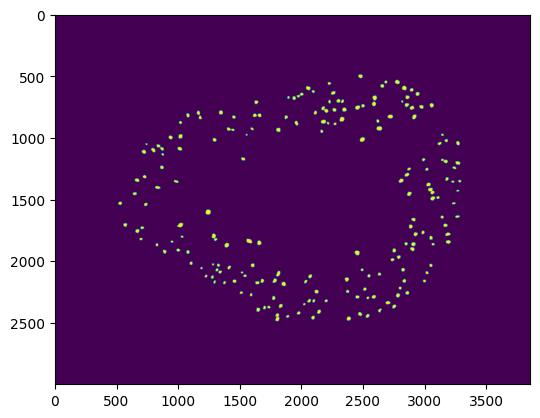

In [10]:
# plot WSI-level mask
plt.imshow(mask_data_resized)

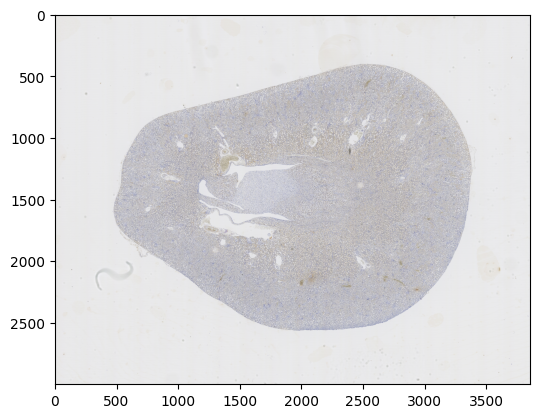

In [11]:
# plot WSI data
plt.imshow(wsi_data_resized)

## Crop each glomerulus annotation mask

In [14]:
anno = random.choice(new_seg_data)

x_min, y_min, x_max, y_max = get_ann_coordinate(anno, wsi_shape=(H, W), crop_size=1024)

# crop image
sub_img = wsi_data[y_min:y_max, x_min:x_max, :]

# crop mask
sub_mask = mask_data[y_min:y_max, x_min:x_max]

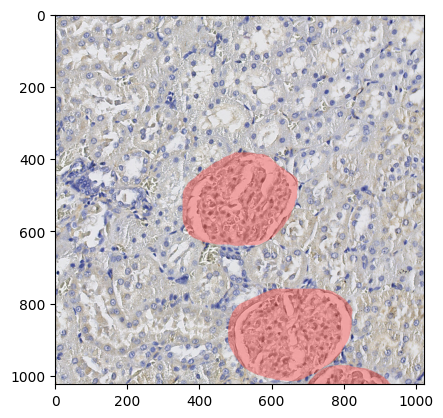

In [15]:
overlay_gt = overlay(sub_img, sub_mask, is_bgr=False)
# visualize cropped image with overlay mask
plt.imshow(overlay_gt)

## Save WSI-level mask (for evaluation)

In [16]:
# not saving these WSI-level masks due to possibly incomplete in labeling
exclusive_wsi_masks = [
    '6666717', '6533672', '6666713', '6533682', '6666711',
]

In [18]:
# saving WSI mask data
wsi_id = Path(wsi_path).stem

if wsi_id not in exclusive_wsi_masks:
    tifffile.imwrite(f'{Path(wsi_path).name}', mask_data)
else:
    print(f'{wsi_id} is in the exclusive list. Skip saving!')